# LAB -- Interacting Hard Spheres

**Please write your name in this box**

*We encourage you to work together, and seek whatever help you need in completing this lab.  Please list all people who you worked with or received help from*

*We encourage you to use any online resources that you find useful. Please list any URL's that you consulted*

*We encourage you to use AI resources if you find them useful.  If you made use of AI, please list the platform and the prompts which you made use of*

## Load in Packages, and set up logger

In [1]:
using Plots,Logging,ProgressMeter,LinearAlgebra

Set up Logger

In [2]:
default_logger=global_logger()
debug_logger=ConsoleLogger(stderr, Logging.Debug); # set up logger

To turn on debug logger as the global logger type

    global_logger(debug_logger)

to turn it off type

    global_logger(default_logger)

## Goal

Here you are going to upgrade our Billiard code to handle interacting hard spheres.  By simulating a large number of such spheres we will be able to explore the kinetic theory of gases, and start thinking about statistical mechanics.

We will again do an `event driven simulation`.  Each ball will have a `nextevent` attribute, which tells what it will next bounce off of, and when.

At each step in the main loop we will figure out which ball has the next collision event -- which could be bouncing off of a wall, or it could be bouncing off of another ball.  We then time evolve up to that point.  We then update all of the `nextevent` fields, and repeat.

We will first do a naive update method which scales quadratically with the number of spheres, $O(N^2)$.  We will then improve that to a linear method, $O(N)$.  We will discuss a $O(N^0)$ method, but will not implement it, as it is a bit of a pain, and our $O(N)$ approach is fast enough for what we want to do. 

The simulation we are producing here can be described as "hard sphere molecular dynamics"

You will probably want the `Billiards.ipynb` file open while you work on this, as we follow a very similar plan here.

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 1
</h2>

We will use a `Ball` class with the following fields:

    mutable struct Ball
        x
        y 
        vx 
        vy 
        radius 
        nextevent 
    end

This is similar to our previous Ball class -- but since we are going to have multiple balls, there is no sense having each one keep track of time.  We also added two new attributes, `radius` and  `nextevent`.  These are the ball's radius, and the object which describes the next collision event.

For efficiency reason, we are going to hard-code the types for these fields.  (We get about a factor of 5 speedup compared to leaving them untyped.  This is because the compiler can optimize some of the code.)  Thus we need to define a "Null Event" object, which can be our default `Event` object.

In [3]:
abstract type Event end

struct NullEvent <: Event
    t ::Float64
end

NE=NullEvent(Inf)

mutable struct Ball
    x ::Float64
    y ::Float64
    vx ::Float64
    vy ::Float64
    radius ::Float64
    nextevent ::Event
end

This is similar to our previous Ball class -- but since we are going to have multiple balls, there is no sense having each one keep track of time.  We also added two new attributes, `radius` and  `nextevent`.  These are the ball's radius, and the object which describes the next collision event.

Based off of the lecture definition, write the following methods:
    
    set_xv!
    set_r!
    set_v!
    get_r
    get_v

Also, overload `Base.show`, and make convenience constructors for the `Ball` class.  As a default you can set `nextevent` equal to `NE`.

Test these methods.

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 2
</h2>

Here are our `Hwall` and `Vwall` classes.  We will not use `Cwall` in this lab, but if we write everything correctly, it should still work.  As with the `Ball` class, I am hard-coding the type declaration for the positions.

In [6]:
abstract type Wall end

struct Hwall <: Wall
    y ::Float64
end

struct Vwall <: Wall
    x ::Float64
end

As in lecture need an `impact_time` method, which finds the but we will need to change it so that it takes 3 variables `impact_time(w::Hwall,b::Ball,t)` -- since our `Ball` objects do not store the time.  

Also, since the balls now have finite radius, you need to change the `impact-time` definition so that the collision happens when the edge of the ball hits the wall, not the center.  Here is how I implemented it for the horizontal wall:

    function impact_time(w::Hwall,b::Ball,t)
        dy=w.y-b.y
        return (dy-sign(b.vy)*b.radius)/b.vy+t
    end

Write the `impact-time` method, and test it.  Make a *method* so that you can call `impact-time` with the Wall and Ball in arbitrary order.

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 3
</h2>

Next we need to define a method 

    impact_time(b1::Ball,b2::Ball,t)

which tells us when 2 balls will collide.  You should be able to do this by calling the `circ_time` function that we made in class.

We will need to call it with `r0=r1-r2`, `v=v1-v2`, and `r=rad1+rad2`,  where `r1` and `r2` are the positions of the two balls, `v1` and `v2` are their velocity vectors, and `rad1` and `rad2` are their radii.  Draw some pictures to convince yourself of the geometry.  You can also imagine doing the problem in different frames.  Convince yourself of the answer when one of the balls is stationary and at the origin.  Then shift frames.

We also need to make one change to `circ_time`: if the two balls are closer than `rad1+rad2` you return `Inf`.  That way if round-off error overlaps the balls, it will not cause them to collide on the inside.

In [42]:
# Here is my code for this

function circ_time(r0,v,r)
    # Calculate the various terms in our expression
    r0dotv=r0⋅v
    if r0dotv>0 #moving away from one another
        return Inf
    end
    vsq=v⋅v
    r0sq=r0⋅r0
    if r0sq<=r^2 #balls are interpenetrating
        return Inf
    end
    discriminant=r0dotv^2+(r^2-r0sq)*vsq  
    if discriminant<0 # balls will never hit one-another
        return Inf
    end
    times=[(-r0dotv-sqrt(discriminant))/(vsq),(-r0dotv+sqrt(discriminant))/(vsq)]
    t1,t2=minmax(times...)
    if t2<=0
        return Inf
    end
    if t1>0
        return t1
    end
    return t2
end

impact_time(b1::Ball,b2::Ball,t)=
    t+circ_time(get_r(b1)-get_r(b2),
        get_v(b1)-get_v(b2),b1.radius+b2.radius)

impact_time (generic function with 4 methods)

Come up with some test cases, to see if this function is behaving properly.

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 4
</h2>

We will now create our event object.  It will simply store the two objects which are involved in the collision, and the time at which the collision will occur.

We will also create our Billiard object, which stores the walls, balls, current time, and the next event.  Lets also store a bounding box there, for visualization.

In [11]:
abstract type Event end

struct Collision <: Event
    object1 :: Union{Ball,Wall}
    object2 :: Union{Ball,Wall}
    t  ::Float64     
end

struct NullEvent <: Event
    t ::Float64
end

NE=NullEvent(Inf)

mutable struct Billiard
    walls ::Array{Wall}
    balls ::Array{Ball}
    t ::Float64
    nextevent ::Event
    boundingbox ::Array{Float64,1}# x1,y1,x2,y2 = corners of a rectangle
end

Billiard(;walls,balls,t=0.,nextevent=NE,boundingbox)=
    Billiard(walls,balls,t,nextevent,boundingbox)

Billiard

Make a function `next_event(b::Ball,billiard::Billiard)`
which will loop through all of the walls and balls in `billiard`, and find their impact time with `b`.  It then finds which collsion will occur next, and create an `event` object corresponding to that collision.

Test with a square billiard containing 2 balls.  Put the balls at various places, and make sure it gives the right answer.

Here is a nice trick for simultaneously looping over walls and balls is to use the `union` function:

In [12]:
b1=Ball(0,0,1,0,0.1,NE)
b2=Ball(0.5,0.,-1,0,0.1,NE)

billiard1=Billiard(walls=[Hwall(1),Vwall(1),Hwall(-1),Vwall(-1)],
    balls=[b1,b2],boundingbox=[-1,-1,1,1])

for x in union(billiard1.walls,billiard1.balls)
    @show x
end

x = Hwall(1.0)
x = Vwall(1.0)
x = Hwall(-1.0)
x = Vwall(-1.0)
x = Ball << r=(0.0, 0.0) v=(1.0, 0.0)>>)
x = Ball << r=(0.5, 0.0) v=(-1.0, 0.0)>>)


<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 5
</h2>

To help debug, at this point it is useful to make a `visualize` function, which plots the billiard.  This will differ from the one we did in class in two ways:  (1) we want to plot multiple balls, and (2) we want the balls to have a well defined radius.

Unfortunately, while the `Plots.scatter` command allows us to control the size of the circles, it does so in a slightly complicated way.  It will be better to write our own circle drawing function (or use a different plotting program -- I think `Makie` can do a better job)

In [15]:
function drawcircles!(centers,radii;opts...)
    c=[cos(θ) for θ in 0:2*pi/100:2pi]
    s=[sin(θ) for θ in 0:2*pi/100:2pi]
    makecircle(center,radius)=Shape(radius*c.+center[1],radius*s.+center[2])
    circles=[makecircle(c,r) for (c,r) in zip(centers,radii)]
    plot!(circles;aspect_ratio=:equal,label="",opts...)
end

function drawcircles!(plt::Plots.Plot,centers,radii;opts...)
    c=[cos(θ) for θ in 0:2*pi/100:2pi]
    s=[sin(θ) for θ in 0:2*pi/100:2pi]
    makecircle(center,radius)=Shape(radius*c.+center[1],radius*s.+center[2])
    circles=[makecircle(c,r) for (c,r) in zip(centers,radii)]
    plot!(plt,circles;aspect_ratio=:equal,label="",opts...)
end

function drawcircles(centers,radii;opts...)
    plt=plot()
    drawcircles!(plt,centers,radii;opts...)
end

drawcircles (generic function with 1 method)

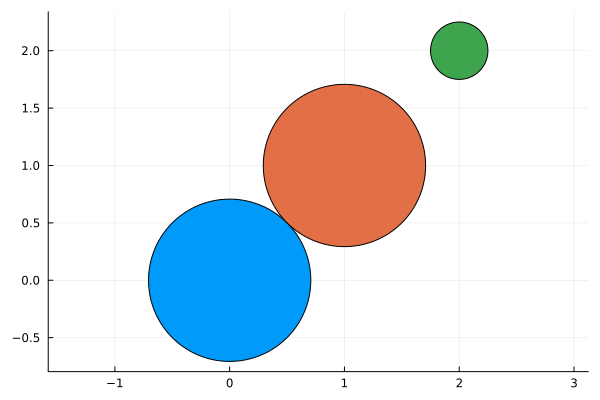

In [16]:
c1=drawcircles([[0,0],[1,1],[2,2]],[sqrt(2)/2,sqrt(2)/2,0.25])

Use this command to write a `visualize(billiard::Billiard)` function which draws the current state of a billiard.  Test.

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 5
</h2>

Write a function `setevents!(billiard::Billiard)` -- which will loop over all the `Balls`, setting their `nextevent` attribute to the output of `next_event`.  Note that for $N$ balls, this take of order $O(N^2)$ time.

As you go, update `billiard.nextevent` with the earliest of these.

In [22]:
billiard1.nextevent

Collision(Ball << r=(0.0, 0.0) v=(1.0, 0.0)>>), Ball << r=(0.5, 0.0) v=(-1.0, 0.0)>>), 0.15)

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 6
</h2>

We already have code for when a ball bounces off of a wall:

In [23]:
reflect(vec,normal)=vec-2*(vec⋅normal)*normal/(normal⋅normal)
normal(w::Hwall,r)=[0,1]
normal(w::Vwall,r)=[1,0]

function newvelocity(w::Wall,b::Ball)
    r=get_r(b)
    n=normal(w,r)
    v=get_v(b)
    return reflect(v,n)
end

function set_newvelocity!(w::Wall,b::Ball)
    v=newvelocity(w,b)
    set_v!(b,v)
    return b
end

set_newvelocity!(b::Ball,w::Wall)=set_newvelocity!(w,b)


set_newvelocity! (generic function with 2 methods)

We need similar code for when two balls bounce off of one-another.  Write a function `set_newvelocity!(b1::Ball,b1::ball)` which sets the velocities of two colliding balls after a collision.  Assume that the balls are in physical contact (so you dont' need to check if they will collide, or find their positions at that time -- we will only call this function when they are at the right locations).

Hint:  In the center of mass frame, the velocities are just reflected using the normal vector at the collision point.  We will assume all of the balls have the same mass, so the center of mass frame is easy to find

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 7
</h2>

Make a method `update!(billiard::Billiard,event::Event)`, which grabs `current_time=billiard.t` and `collision_time=event.t`.  It updates the positions of the balls as they move in a straight line path between those times.  (for that you might want to make a `time_evolve(b:Ball,dt)` method.  Your `update!` method should then calls `set_newvelocity!` on the objects in the event.  Finally it should update `billiard.t`.

A good way to test this is to first generate a `Billiard`:

    b1=Ball(0,0,1,0,0.1,NE)
    b2=Ball(0.5,0.,-1,0,0.1,NE)
    billiard1=Billiard(walls=[Hwall(1),Vwall(1),Hwall(-1),Vwall(-1)],
        balls=[b1,b2],boundingbox=[-1,-1,1,1])
    visualize(billiard1)

Run that, then in a new cell run

    setevents!(billiard1)
    update!(billiard1,billiard1.nextevent)
    visualize(billiard1)

Every time you run that cell it should update the billiard, and the visualization.  Do that a bunch of times to see if it is acting correctly.

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 8
</h2>

Now you have all the ingredients that you need for the simulation.  We need to figure out, however, how we will deliver the output.  Lets use the following data structure

In [30]:
struct State
    xvalues ::Array{Float64,1}
    yvalues ::Array{Float64,1}
    vxvalues ::Array{Float64,1}
    vyvalues ::Array{Float64,1}
    radii ::Array{Float64,1}
    t ::Float64
end

struct Simulationdata
    walls :: Array{Wall}
    statelist :: Array{State}
    boundingbox ::Array{Float64,1}
end

Base.length(s::Simulationdata)=length(s.statelist)

The object `State` will contain the x,y,vx,yv for each of the balls in the current state of the system.

Write a function which creates a state object from a Billiard

    function State(b::Billiard)
        ...
    end

Also make a function which can be used to visualizes a state:

    function visualize!(plt::Plots.Plot,s::State;opts...)

test the state creation and visualization.  Note, this `visualize` should only draw the balls -- you will separately draw the walls.

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 9
</h2>

Make your main loop 

    function simulate(billiard::Billiard,n)

that takes a `Billiard`, and time-evolves it for a fixed number of collisions.  It then returns the a `Simulationdata` object.

Test with a small run with a couple balls, and just a few collisions.

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 10
</h2>

Now we need some visualization. The first thing we need is a function which draws the configuration for a single frame of our simulation data, something like

In [35]:
function drawframe(s::Simulationdata,j)
    walls=s.walls
    bbox=s.boundingbox
    plt=plot()
    for w in walls
        visualize!(plt,w,bbox;label="")
    end
    visualize!(plt,s.statelist[j])
end

drawframe (generic function with 1 method)

Test to see if this works by running your `simulate` function for a few collisions, and draw some of the resulting configurations

Now here is a minimal implementation of a `eventanimate` function.  Here `skip` is an integer which lets us skip frames to speed up the animation when we have lots of balls

In [36]:
function eventanimate(s::Simulationdata,skip=1)
    # print out a message to let the user know things are starting
    @info "Animating Simulation"
    len=length(s)
    progress_meter=Progress(len,desc="Generating frames: ")
    anim =  @animate for i in 1:skip:len
        ProgressMeter.update!(progress_meter,i)
        drawframe(s,i)
    end
    Plots.gif(anim, fps = 12)
end

eventanimate (generic function with 2 methods)

Test it out with just a couple balls.  It should be pretty jumpy, but that is OK -- we are going to want to work with many balls, which will smooth it out.

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 11
</h2>

Now we need to automate initial conditions.  For simplicity, lets start the balls on a $n_x\times n_y$ grid (so there will be $N=n_x n_y$ balls).  We will give each of them speed 1, with a velocity vector pointing in a random direction.  

Make a function that takes the $n_x$, $n_y$, the radii of the balls, and the dimensions of the Billiard.  It should then produce the desired configuration.

Test it with $L_x=L_y=1$,  $n_x=n_y=10$, and use a radius of $0.01$.  For me running a simulation with 100 collisions took about 0.2s. Use `@time` to see how long it takes you.

Look at individual frames (using `drawframe`).  If all is good, then make an animation.  If the animation runs too slow, use the `skip` argument in `eventanimate`.

To get a uniformly distributed random number you can use

In [38]:
using Random
rand()

0.12809762082947007

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 12
</h2>

We now want to make things faster.  100 collisions in 0.2s is too slow for me.  We are going to want to do many thousands of collisions.

The biggest algorithmic bottleneck is that in every step we update the collisions for every single ball.

The current code should look something like this:

    function setevents!(billiard::Billiard)
        t_global=Inf
        for b in billiard.balls
            next=next_event(b,billiard)
            b.nextevent=next
            if next.t<t_global
                t_global=next.t
                billiard.nextevent=next
            end
        end
        return billiard
    end

We are looping through every single ball, and calculating its collision time with every other ball, using the `next_event` method.  This is wasteful: we only need to calculate times with the balls in the last event.

We want to make a new version of `setevents!`, that is called with the billiard, and the last event, and then only updates the things which we know might have changed:

    function setevents!(billiard::Billiard,lastevent::Collision)

Here is the algorithm:

The first thing we do is make a list of all the `Ball` objects in `lastevent`.  Suppose there is just one of them -- lets call it `b0`.  We set `b0.nextevent` to be equal to the null event `NE`.  We also set `billiard.nextevent` to the null event.

We will then loop through all of the balls in billiard.  For each ball `bj` we calculate the next collision time between `b0` and `bj`.  If that collision time is shorter than `b0.nextevent.t`, we update `b0.nextevent` to be the collision between `b0` and `bj`.  Similarly if that collision time is shorter than `bj.nextevent.t` we update `bj.nextevent`.  

We then look at `b0.nextevent.t` and `bj.nextevent.t`.  If either is before `billiard.nextevent.t` then we update `billiard.nextevent`.

Finally, we need to loop through all of the walls, and if any of their collisions with `b0` are shorter than `b0.nextevent.t` we update `b0.nextevent`.  If that collision time is shorter than `billiard.nextevent.t` we also update `billiard.nextevent`.

After looping through all of the balls (and walls), we will have upddated all of the `nextevent` objects -- but only required a $O(N)$ time. For comparison, the previous algorithm required $O(N^2)$ time.
Thus for 100 balls this will run 100 times faster.

Write this new version of `setevents!`, and test it.  Here is how I did my tests:  In one cell I ran:

    rb2=randomgrid(2,2,0.01,1,1)
    visualize(rb2)

then in the next cell I repeatedly ran:

    setevents!(rb2,rb2.nextevent)
    update!(rb2,rb2.nextevent)
    visualize(rb2)

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 13
</h2>

Now write an updated version of `simulate` -- which calls the new `setevents!`.  Test

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 14
</h2>

Just like the Sinai Billiard, this system is chaotic. In fact, it is a specific type of chaotic system which is referred to as Ergodic.   If one runs the simulation for enough time, one expects to uniformly sample all possible configurations of the balls which are consistent with the initial conditions.

In practice this means the only constraint is that the total energy is conserved.  As we will discuss in lecture, this means that if we have a large number of balls, and all the balls start out with velocity 1, then at long times we expect the velocity distribution of each ball to be drawn randomly from a Maxwell-Boltzmann distribution,
\begin{equation}
P(v)= 2 v \exp(-v^2).
\end{equation}

To test this out, what you want to do is run a simulation with ~100 Balls (so a 10x10 grid) for a large number of collisions (say 5000). The ball radius is not so critical here.  Something like `radius=0.01` works well if the box sides have length 1. Take the last state, and make a list of the speeds of all the particles.  Use the `histogram` function to plot them.  Given that there are only 100 speeds, the histogram will be pretty blocky.  Note, `histogram` takes an argument `normalize=true`, which will normalize it to make a probability distribution function.

Draw the theoretical curve on the histogram. 

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 13
</h2>

To get better resolution on our histogram, we want to bin together data at different times.  We would naively expect that after ~$N$ collisions we should get a statistically independent set of velocities.  Here is a function which makes a list of speeds from a frame of the simulation data.

In [69]:
"""
    speedlist(sim::Simulationdata,frame::Integer)

Makes a list of the speeds of all of the particles in frame number 
`frame` of the simulation data.  You can also call it with a list of
frames and it will concatentate those lists.

For example, you can call with

    speedlist(s,[1,3,5])

and get the speeds in frames 1, 3, 5.  We can even use

    speedlist(s,1::10::100)

which will do every 10'th frame between 1 and 100.
"""
speedlist(sim::Simulationdata,frame::Integer) =
    sqrt.(sim.statelist[frame].vxvalues.^2
            +sim.statelist[frame].vyvalues.^2)

speedlist(sim::Simulationdata,frames)=
    vcat([speedlist(sim,j) for j in frames]...)

speedlist (generic function with 2 methods)

Run your simulation for another 50,000 collisions, and make a Histogram that contains the speeds from every 100'th frame.  (Which will give you 50,000 speeds).  Again compare with the Maxwell-Boltzmann expectation.

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:blue; color:white;" >
## Bonus 1
</h2>

With some rather small changes, one can incorporate different masses into the simulation.  You could then have large heavy particles and small light particles scattering off one-another.  It could be fun to do that.  **This is fully optional**

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:blue; color:white;" >
## Bonus 2
</h2>

It turns out that there are a number of further algorithmic improvements that we can make.  Follow 
[this link](https://arxiv.org/pdf/2201.01100]) for a practical review.  Another, slightly broader discussion can be found [here](https://pubs.aip.org/aip/jcp/article/157/23/234111/2842446/Hard-disk-pressure-computations-a-historic).

The next improvements take a bit of work -- and you only should do them if it interests you.  **This is fully optional**

The first trick is that we can do *asynchronous updates*.  Each ball can have its own clock.  In the `update!` step we only need to update the positions of the balls that were involved in the collision.  We then need to modify the `collision_time` method, so that it can act on balls whos positions are given at different time:  For example, suppose `ball1` is at position `x1` at time `t1`, and `ball2` is at position `x2` at time `t2`.  If these had vanishing radii, the collision time sattisfies
\begin{equation}
\vec{x_1}+(t-t_1)\vec{v_1}=\vec{x_2}+(t-t_2)\vec{v_2}
\end{equation}
which is readily solved for $t$.  This is easily incorporated into our functions.

The second trick is to divide the `billiard` into spatial cells.  Each ball is placed in a cell.  Possible events include scattering with other particles in the same cell, or hitting the cell boundary -- in which case the particle is moved to the neighboring cell.  Because we only need to worry about collisions in the same cell, this converts the problem of finding the next collision from $O(N)$ to $O(1)$.

Using these two tricks we get a speedup by another factor of $N$ -- so roughly $100$ for the cases we have been considering.